# Load tfrecords, define model and train

In [1]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

#Tensorboard
%load_ext tensorboard


# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import datetime        
from scipy.io.wavfile import write


# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
GPU not available :(


In [2]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300

# print config
#print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


# load tfrecords

### funcs 

In [60]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)
    
    return voicefixer, produced


def slicing_audio(voicefixer, produced):
    # generate random integer between 0 and 10*44100-3*44100
    random_int = tf.random.uniform(shape=[], minval=0, maxval=7*44100, dtype=tf.int32)
    # slice audio
    voicefixer = voicefixer[random_int:random_int+3*44100]
    produced = produced[random_int:random_int+3*44100]
    return voicefixer, produced
 

#--------------------------------------------
# helper func
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


#--------------------------------------------
# get audiofile from dataset and use as input for prediction
def set_speechfile(test_dataset, log_dir):


    dataset = test_dataset.unbatch().as_numpy_iterator()
    speech_for_predicition = []
    for i, sample in enumerate(dataset):
        speech_for_predicition.append(sample[0])
        break
    # # normalize speechfile
    speech_for_predicition = speech_for_predicition[0]
    speech_for_predicition = librosa.util.normalize(speech_for_predicition)
    
    # save speech file used for prediction
    # save plot to disk
    plt.figure(figsize=(8, 4))
    x = np.arange(0, len(speech_for_predicition)/44100, 1/44100)
    plt.plot(x, speech_for_predicition)
    plt.title('Speechfile used for prediction')
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    plt.savefig(log_dir + '/_audiofile_for_prediction.png')
    plt.show()
    
    # save audiofile to disk
    write(log_dir + '/_audiofile_for_prediction' + '.wav', int(44100), float2pcm(speech_for_predicition))
   
    return speech_for_predicition


#--------------------------------------------
# save audio files from logs to tf.summary.audio and event files for tensorboard
def save_audio_to_summaries(log_dir):
    
        # get audio files from logs
        fps = glob.glob(log_dir + '/*.wav')
        path_audiosummary = log_dir + '/audiosummary/'

        # for each audio file
        for idx, fp in enumerate(fps):
            
            # write audiosummary of one audio file to disk
             writer = tf.summary.create_file_writer(path_audiosummary)
             with writer.as_default():
                
                # load audio file as tensor
                file = tf.io.read_file(fp)
                audio = tf.audio.decode_wav(file, desired_channels=1)

                # write audio file to tf.summary.audio
                name = fp.split('/')[-1]
                tf.summary.audio(name , tf.expand_dims(audio[0], 0), int(44100), step=idx)
                writer.flush()


#--------------------------------------------
import tensorflow as tf


class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(y_mag, ord="fro", axis=(-2, -1))


class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag) - tf.math.log(x_mag))


class TFSTFT(tf.keras.layers.Layer):
    """STFT loss module."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """

        x_mag = tf.abs(tf.signal.stft(signals=x,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))
        y_mag = tf.abs(tf.signal.stft(signals=y,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))

        # add small number to prevent nan value.
        # compatible with pytorch version.
        x_mag = tf.math.sqrt(x_mag ** 2 + 1e-7)
        y_mag = tf.math.sqrt(y_mag ** 2 + 1e-7)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss
    
    
class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(self,
                 fft_lengths=[1024, 2048, 512],
                 frame_lengths=[600, 1200, 240],
                 frame_steps=[120, 240, 50],):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(frame_lengths, frame_steps, fft_lengths):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l)
            mag_loss += tf.reduce_mean(mag_l)

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return mag_loss


#--------------------------------------------
class CustomLoss(tf.keras.losses.Loss):
    """custom loss calculated from MAE and Multiresolution STFT loss"""

    def __init__(self):
        super().__init__()
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.stft = TFMultiResolutionSTFT()


    def call(self, y_true, y_pred):
        mae = self.mae(y_true, y_pred)
        stft = self.stft(y_true, y_pred)
        return (mae + stft / 2)




(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)


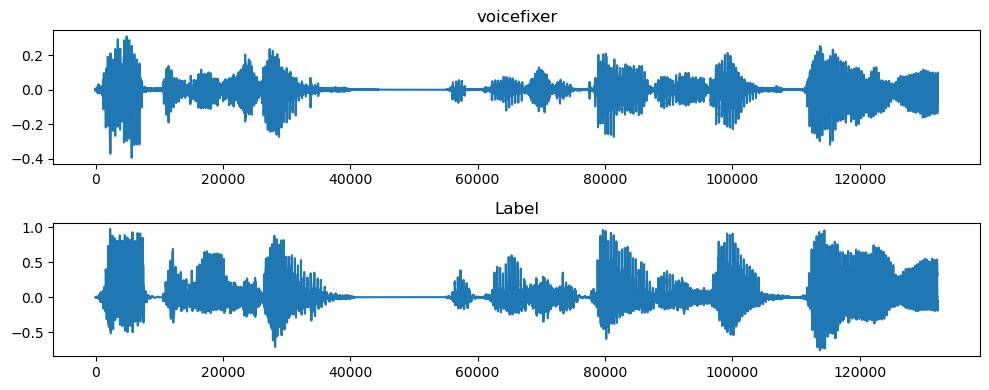

Stft loss is:1.2207120656967163
MAE loss is:0.0869392678141594
custom loss is:0.6972953081130981
-------------------
Stft loss is:1.2092475891113281
MAE loss is:0.10098836570978165
custom loss is:0.7056121826171875
-------------------
Stft loss is:1.125846028327942
MAE loss is:0.07445577532052994
custom loss is:0.6373788118362427
-------------------
Stft loss is:1.1607502698898315
MAE loss is:0.10453834384679794
custom loss is:0.6849134564399719
-------------------
Stft loss is:1.3023138046264648
MAE loss is:0.08757615089416504
custom loss is:0.7387330532073975
-------------------
Stft loss is:1.1931575536727905
MAE loss is:0.10135558247566223
custom loss is:0.6979343891143799
-------------------
Stft loss is:1.1576544046401978
MAE loss is:0.0925733894109726
custom loss is:0.6714006066322327
-------------------
Stft loss is:1.1561857461929321
MAE loss is:0.11729107797145844
custom loss is:0.6953839659690857
-------------------
Stft loss is:1.2236751317977905
MAE loss is:0.0988537818193

In [62]:
import numpy as np
loss1 = TFMultiResolutionSTFT()
loss2 = tf.keras.losses.MeanAbsoluteError()
loss3 = CustomLoss()


# load train tfrecords
path = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
DS = tf.data.TFRecordDataset(path[:5])
DS = DS.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
DS = DS.map(slicing_audio, num_parallel_calls=AUTOTUNE)


sf = []
label = []

for y, X in DS.take(10):
  print(y.numpy().shape, X.numpy().shape)
  sf.append(y.numpy().T)
  label.append(X.numpy().T)


# # transpose 
# file = tf.transpose(sf[0])
# file2 = sf[0].T

# print(file.shape)
# print(file2.shape)


# plot waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)     
plt.title('voicefixer')
plt.plot(sf[0].T)
plt.subplot(2, 1, 2)
plt.title('Label')
plt.plot(label[0].T)
plt.tight_layout()
plt.show()



for i in range(len(sf)):
  print(f'Stft loss is:{loss1(label[i], sf[i])}')
  print(f'MAE loss is:{loss2(label[i], sf[i])}')
  print(f'custom loss is:{loss3(label[i], sf[i])}')
  print('-------------------')




In [6]:
# load train tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths[:5])
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in train_dataset: 300


In [5]:
# load test tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths[:2])
test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in test_dataset
print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in test_dataset: 120


In [6]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)
(16, 132300, 1)


## Model architecture

In [7]:
# some values for training
config['n_epochs'] = 20
config['learning_rate'] = 0.004
# Filter:Kernel = 4:1 (see hifi-gan paper)
config['filter_size'] = 16
config['kernel_size'] = 4
config['dropout_rate'] = 0.5

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

In [8]:
# some values for the model
input_shape = (3*44100, 1)
output_channels = 1


# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
    # add dropout layer, batch normalization and activation layer
    #model.add(keras.layers.Dropout(config['dropout_rate']))
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(8):
        model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
        # add dropout layer, batch normalization and activation layer
        #model.add(keras.layers.Dropout(config['dropout_rate']))
        #model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer without activation layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    #model.add(keras.layers.Dropout(config['dropout_rate']))
    #model.add(keras.layers.BatchNormalization())

    return model

2023-07-19 09:58:05.253037: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-07-19 09:58:05.253064: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-07-19 09:58:05.253381: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


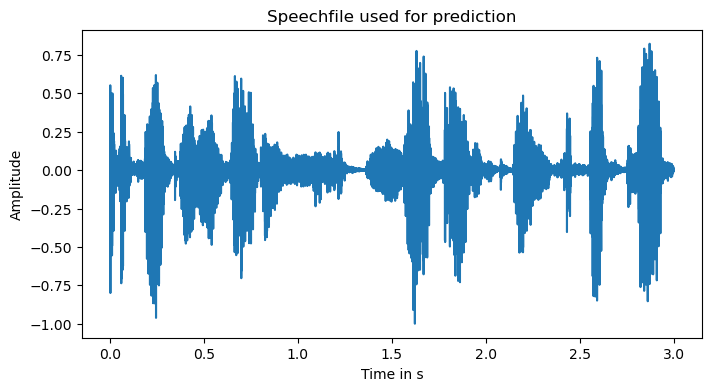

Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 132300, 16)        80        
                                                                 
 activation (Activation)     (None, 132300, 16)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 132300, 16)        1040      
                                                                 
 activation_1 (Activation)   (None, 132300, 16)        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 132300, 16)        1040      
                                                                 
 activation_2 (Activation)   (None, 132300, 16)        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 132300, 16)     

In [9]:
# initialize log_dir
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# make directory if not exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


#--------------------------------------------
# define callbacks

save_callback = keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint',
    save_best_only=False,
    monitor='val_loss',
    verbose=0)

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir= log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

# early_stopping_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1)


# get speechfile for prediction
speech_for_predicition = set_speechfile(test_dataset, log_dir)

#--------------------------------------------
# define custom callback
class CustomCallback(keras.callbacks.Callback):
     
    # define functions to happen during training after each epoch
    def on_epoch_end(self, epoch, logs=None):
        
        # # print(logs) to check metrics
        # print('---------------------')
        # print(f'Epoch {epoch+1} Metrics:')
        # print(logs)
        # print('---------------------')
        # print('')
        

        # save predicted audio file after each epoch to disk
        # get audio file from model prediciton
        audio = self.model.predict(speech_for_predicition)

        # change shape to (len(audio), 1)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.squeeze(audio, axis=-1).numpy()
        #print(audio.shape)

        # normalize audio with numpy
        audio = librosa.util.normalize(audio).astype(np.float32)

        # save plot to disk
        plt.figure(figsize=(8, 4))
        x = np.arange(0, len(audio)/44100, 1/44100)
        plt.plot(x, audio)
        plt.title('Audiofile')
        plt.xlabel('Time in s')
        plt.ylabel('Amplitude')
        plt.savefig(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.png')
        plt.close()

        # write audio file to disk (16-bit PCM WAV)
        write(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.wav', 44100, float2pcm(audio))


#--------------------------------------------
# get model
model = build_model(input_shape = input_shape)

# compile model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss = CustomLoss(),
              metrics = tf.keras.losses.MeanAbsoluteError())

model.summary()


In [47]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [10]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=[save_callback, tensorboard_callback, CustomCallback()])

# save model
model.save('./model.h5')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)


# call def to save audio to summaries
save_audio_to_summaries(log_dir)


Epoch 1/20


ValueError: in user code:

    File "/Users/marius/opt/anaconda3/envs/Masterarbeit/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/marius/opt/anaconda3/envs/Masterarbeit/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/marius/opt/anaconda3/envs/Masterarbeit/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/marius/opt/anaconda3/envs/Masterarbeit/lib/python3.9/site-packages/keras/engine/training.py", line 891, in train_step
        self._validate_target_and_loss(y, loss)
    File "/Users/marius/opt/anaconda3/envs/Masterarbeit/lib/python3.9/site-packages/keras/engine/training.py", line 857, in _validate_target_and_loss
        raise ValueError(

    ValueError: No loss found. You may have forgotten to provide a `loss` argument in the `compile()` method.


In [ ]:
%tensorboard --logdir logs

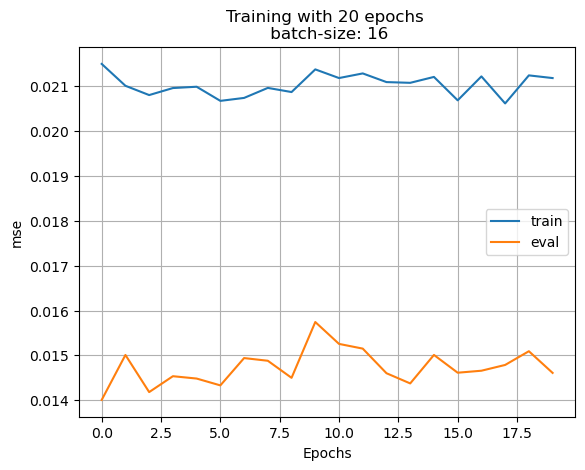

In [85]:
# plot mse
train_mse = history.history['mean_squared_error']
eval_mse = history.history['val_mean_squared_error']

fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_mse, label='train')
plt.plot(range(config['n_epochs']), eval_mse, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  

In [ ]:
# reconstructed_model = keras.models.load_model('./model.h5')


# look at data

In [12]:
# # look at some example data from train dataset
# wavs = train_dataset.unbatch().as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')